<a href="https://colab.research.google.com/github/PamelaCarina/bitcoin_prediction/blob/master/bitcoin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
from statsmodels.tsa.stattools import adfuller #test estadístico que se usa para saber si los datos son estacionarios
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from scipy import stats
import statsmodels.api as sm
import statsmodels as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# esto es opcional, lo utilizamos para colaborar engrupo en colab, importando el archivo directamente desde google drive, se puede omitir si ya se tiene el dataset en el pc
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Estacionaridad de los datos (Mensual)




In [ ]:
#para trabajar en grupo se hizo en colab, el data set puede ser cargado directamente desde el pc si se utiliza jupyter estableciendo el directorio del dataset

df = pd.read_csv("/content/drive/My Drive/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.dtypes
df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [ ]:
def missing(df):
    total=df.isnull().sum()
    percent=df.isnull().sum()/len(df)
    return pd.concat([total,percent],axis=1,keys=['total','percent'])
missing(df)

,total,percent
Timestamp,0,0.000000
Open,1243608,0.256025
High,1243608,0.256025
Low,1243608,0.256025
Close,1243608,0.256025
Volume_(BTC),1243608,0.256025
Volume_(Currency),1243608,0.256025
Weighted_Price,1243608,0.256025


In [ ]:


df['Timestamp']=pd.to_datetime(df['Timestamp'], unit='s')
df=df.dropna().reset_index(drop=True)
df = df.set_index('Timestamp')
df.index

DatetimeIndex(['2011-12-31 07:52:00', '2011-12-31 15:50:00',
               '2011-12-31 16:59:00', '2011-12-31 17:00:00',
               '2012-01-01 04:16:00', '2012-01-01 15:28:00',
               '2012-01-01 22:45:00', '2012-01-02 20:04:00',
               '2012-01-03 11:45:00', '2012-01-03 14:22:00',
               ...
               '2021-03-30 23:50:00', '2021-03-30 23:51:00',
               '2021-03-30 23:53:00', '2021-03-30 23:54:00',
               '2021-03-30 23:55:00', '2021-03-30 23:56:00',
               '2021-03-30 23:57:00', '2021-03-30 23:58:00',
               '2021-03-30 23:59:00', '2021-03-31 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=3613769, freq=None)

In [ ]:

df_day=df.resample('D').mean()

df_month=df.resample('M').mean()
df_year=df.resample('Y').mean()
df_quarter=df.resample('Q').mean()
df_week=df.resample('W').mean()
df_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 2011-12-31 to 2021-03-31
Freq: M
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               112 non-null    float64
 1   High               112 non-null    float64
 2   Low                112 non-null    float64
 3   Close              112 non-null    float64
 4   Volume_(BTC)       112 non-null    float64
 5   Volume_(Currency)  112 non-null    float64
 6   Weighted_Price     112 non-null    float64
dtypes: float64(7)
memory usage: 7.0 KB


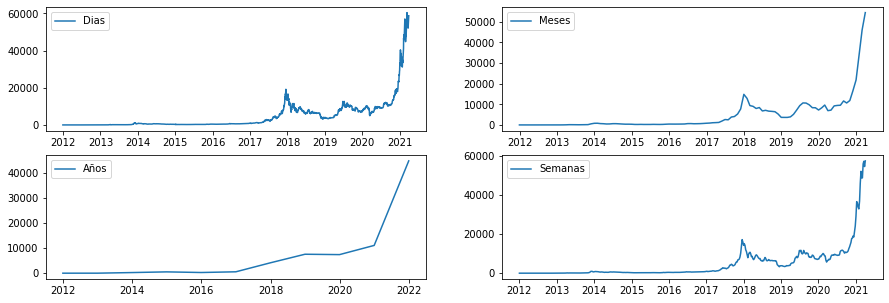

In [ ]:

fig = plt.figure(figsize=[15, 5])
plt.subplot(221)
plt.plot(df_day.Weighted_Price, '-', label='Dias')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='Meses')
plt.legend()

plt.subplot(223)
plt.plot(df_year.Weighted_Price, '-', label='Años')
plt.legend()

plt.subplot(224)
plt.plot(df_week.Weighted_Price, '-', label='Semanas')
plt.legend()

<Figure size 5760x5760 with 0 Axes>

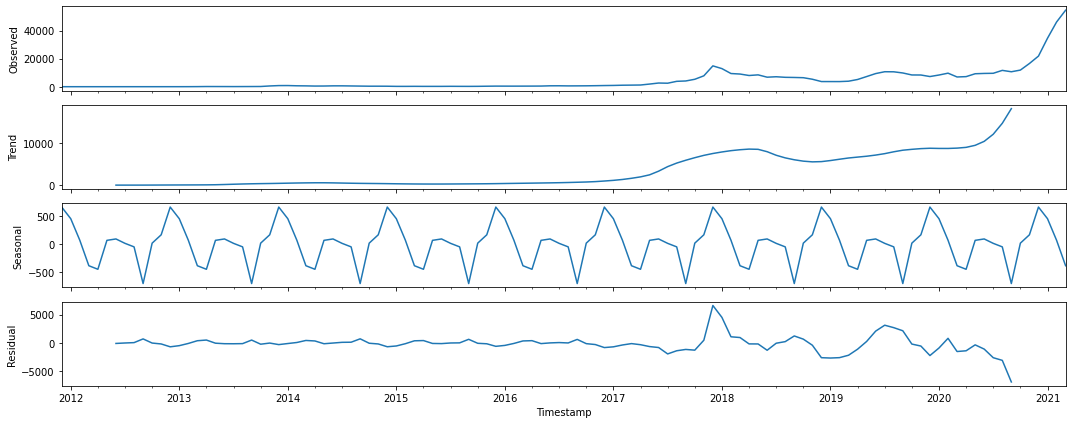

In [ ]:
plt.figure(figsize=[80,80])
sm.tsa.seasonal.seasonal_decompose(df_month.Weighted_Price).plot()
plt.show()


In [ ]:

mes=adfuller(df_month.Weighted_Price)
dia=adfuller(df_day.Weighted_Price.dropna())
anio=adfuller(df_year.Weighted_Price)
cuartil=adfuller(df_quarter.Weighted_Price)
print('p-value mes: %f'%mes[1])
print('p-value dia: %f'%dia[1])
print('p-value anio: %f'%anio[1])
print('p-value cuartil: %f'%cuartil[1])

p-value mes: 0.998833
p-value dia: 1.000000
p-value anio: 1.000000
p-value cuartil: 0.999082


In [ ]:
def test_stationarity(x):    
    # Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %0.6f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("No es estacionario")
            break
         else:
            print("Se rechaza hipotesis nula, dato es estacionario")
            break;


In [ ]:
ts=df
test_stationarity(df_month.Weighted_Price)




ADF Stastistic: 2.143886
p-value: 0.998833
No es estacionario


In [ ]:
from scipy import stats

#transformada logaritmica de los datos:

ts_logtrsform = np.log(df_month.Weighted_Price)
test_stationarity(ts_logtrsform)
#transformada box_cox:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
test_stationarity(df_month.Weighted_Price_box)

ADF Stastistic: -1.079259
p-value: 0.723272
No es estacionario
ADF Stastistic: -0.293579
p-value: 0.926409
No es estacionario


In [ ]:
#Diferenciacion seasonal:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
df_month=df_month.dropna()
test_stationarity(df_month.prices_box_diff)

ADF Stastistic: -1.678562
p-value: 0.442190
No es estacionario


ADF Stastistic: -6.291592
p-value: 0.000000
Se rechaza hipotesis nula, dato es estacionario


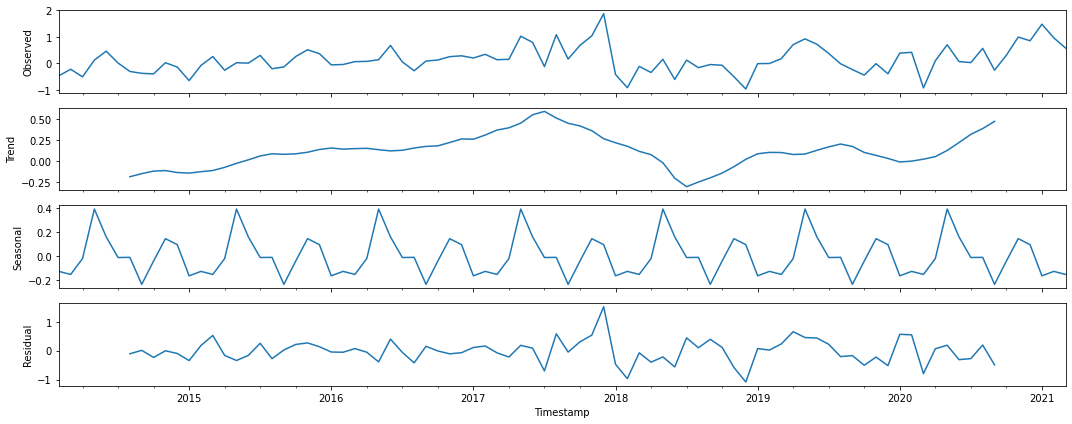

In [ ]:

#Diferenciacion de primer orden: 

df_month['prices_box_diff2']=df_month.Weighted_Price_box-df_month.Weighted_Price_box.shift(1)
df_month=df_month.dropna()
test_stationarity(df_month.prices_box_diff2)


#descomposicion STL

seasonal_decompose(df_month.prices_box_diff2[13:],freq=12).plot()  
plt.show()

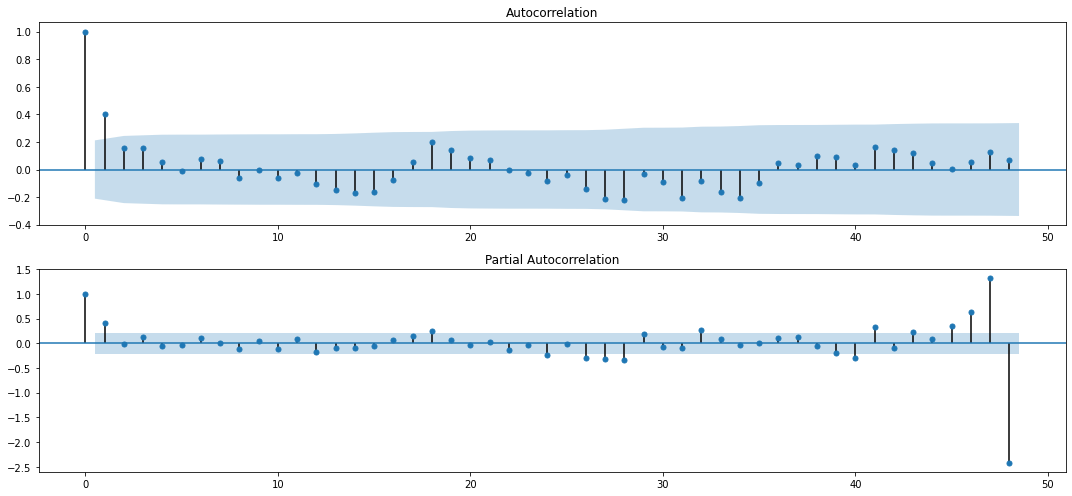

In [ ]:
import statsmodels.api as sm
import statsmodels as sm


plt.figure(figsize=(15,7))
ax = plt.subplot(211)

sm.graphics.tsaplots.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)

sm.graphics.tsaplots.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()


# Evaluar modelo

In [ ]:

# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0)  155.384224
7     (2, 1)  156.185012
4     (1, 1)  157.322391
6     (2, 0)  157.340141
1     (0, 1)  158.003475


In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:     Weighted_Price_box   No. Observations:                   99
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -75.692
Date:                Thu, 05 Aug 2021   AIC                            155.384
Time:                        22:44:51   BIC                            160.554
Sample:                    01-31-2013   HQIC                           157.475
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4713      0.072      6.541      0.000       0.330       0.612
sigma2         0.2737      0.026     10.360      0.000       0.222       0.325
Ljung-Box (Q):                       27.56   Jarque-

In [ ]:
test_stationarity(best_model.resid[13:])

ADF Stastistic: -9.770670
p-value: 0.000000
Se rechaza hipotesis nula, dato es estacionario


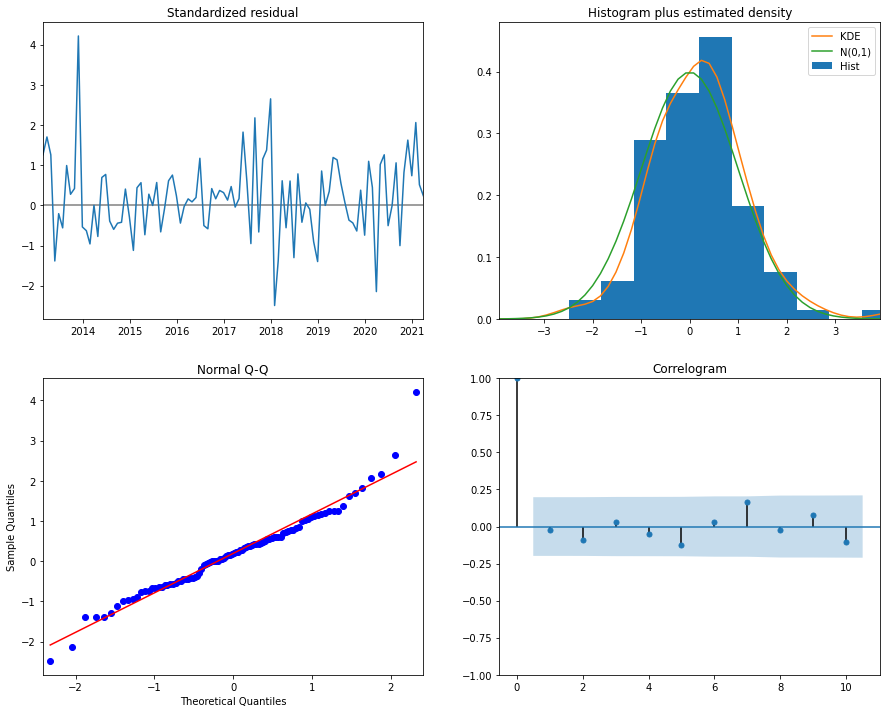

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Predicción (Mensual)

In [ ]:
from datetime import datetime, timedelta

# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

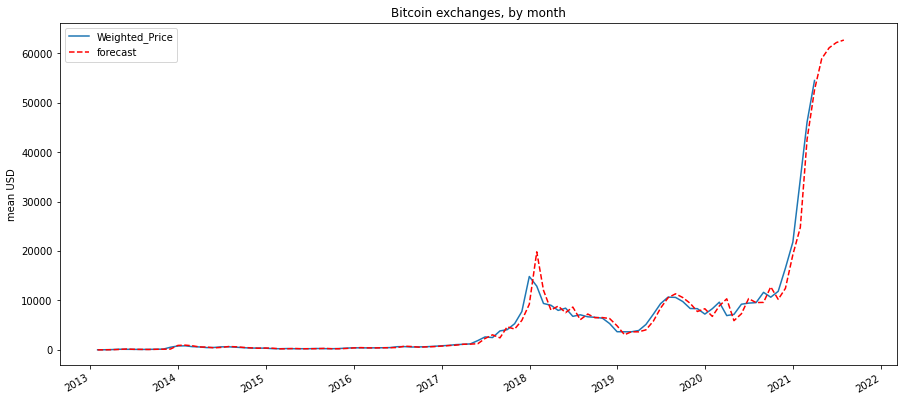

In [ ]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 3 , 31), datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021, 6, 30), datetime(2021, 7, 31), datetime(2021, 8, 30),datetime(2021, 9, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=120), lmbda)

plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin exchanges, by month')
plt.ylabel('mean USD')
#plt.xlim([datetime(2012, 8 , 31), datetime(2021, 12, 31)])
plt.show()

In [ ]:
y_forecasted = df_month2.forecast
y_truth = df_month2['2012-01-01':'2017-01-01'].Weighted_Price

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 82.97


In [ ]:
y_forecasted = df_month2.forecast
y_truth = df_month2['2017-01-01':'2021-01-01'].Weighted_Price

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 1867.14


In [ ]:
mae=np.mean(np.abs(y_forecasted-y_truth))
print('Mean Absolute Error: {}'.format(round(mae, 2)))

Mean Absolute Error: 1274.95


In [ ]:
mape=np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('Mean Absolute Percentage Error: {}'.format(round(mape, 2)))

Mean Absolute Percentage Error: 16.1


# Estacionaridad para datos (diarios)


Dickey–Fuller test: p=1.000000


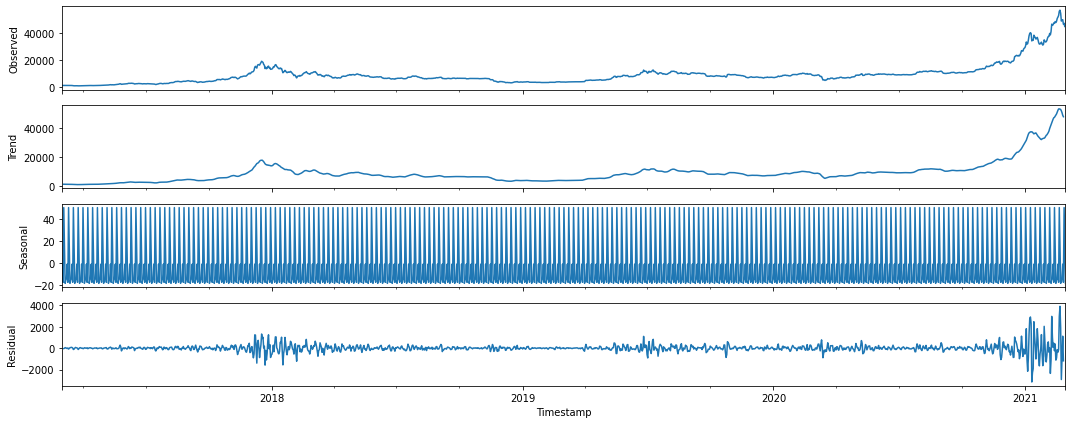

In [ ]:

df_day=df_day['2017-03-01':'2021-03-01']
df_day=df_day.dropna()

seasonal_decompose(df_day.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % adfuller(df_day.Weighted_Price)[1])
plt.show()

In [ ]:


#transformada box_cox:
df_day['Weighted_Price_box'], lmbda = stats.boxcox(df_day.Weighted_Price)
test_stationarity(df_day.Weighted_Price_box)


ADF Stastistic: -0.455504
p-value: 0.900411
No es estacionario


In [ ]:
#seasonal diff (semanal)
df_day['prices_box_diff'] = df_day.Weighted_Price_box - df_day.Weighted_Price_box.shift(7)
df_day=df_day.dropna()
test_stationarity(df_day.prices_box_diff)




ADF Stastistic: -6.750100
p-value: 0.000000
Se rechaza hipotesis nula, dato es estacionario


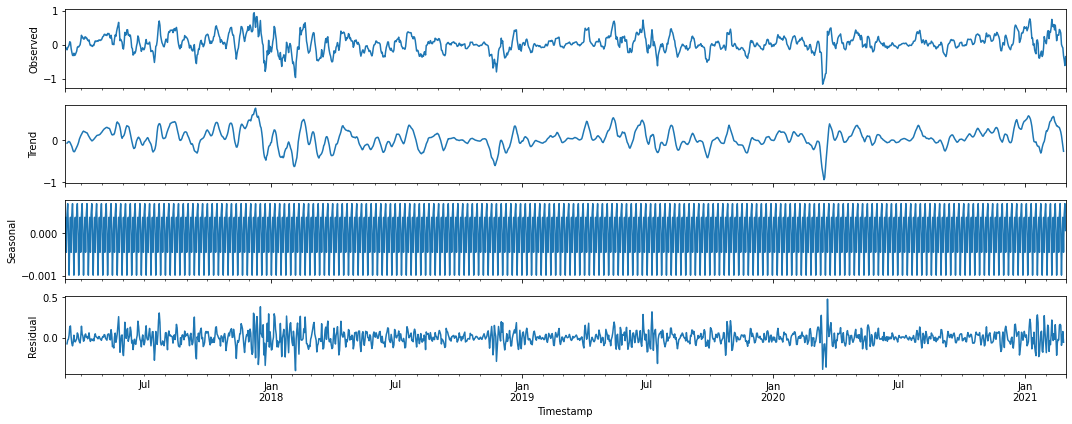

In [ ]:
seasonal_decompose(df_day.prices_box_diff).plot()
plt.show()

In [ ]:
#seasonal diff
df_day['prices_box_diff2'] = df_day.prices_box_diff - df_day.prices_box_diff.shift(1)
df_day=df_day.dropna()
test_stationarity(df_day.prices_box_diff2)


ADF Stastistic: -11.430297
p-value: 0.000000
Se rechaza hipotesis nula, dato es estacionario


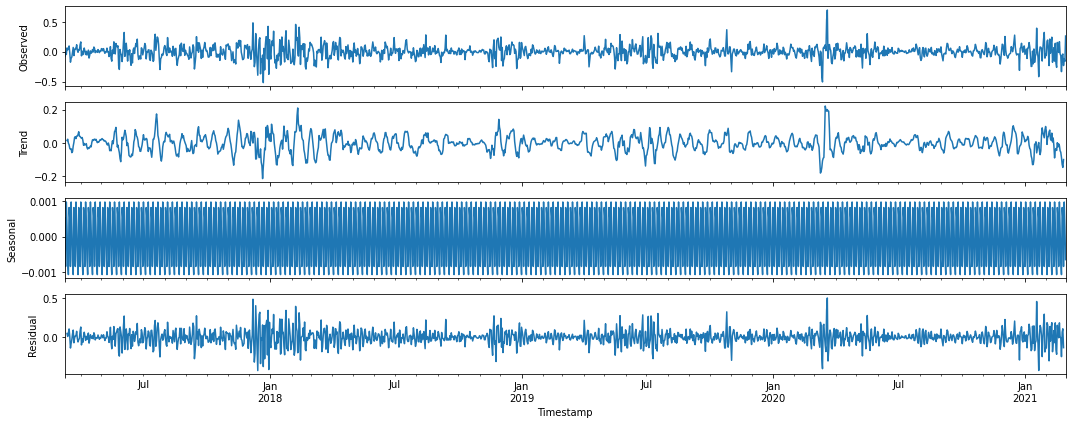

In [ ]:
seasonal_decompose(df_day.prices_box_diff2).plot()
plt.show()

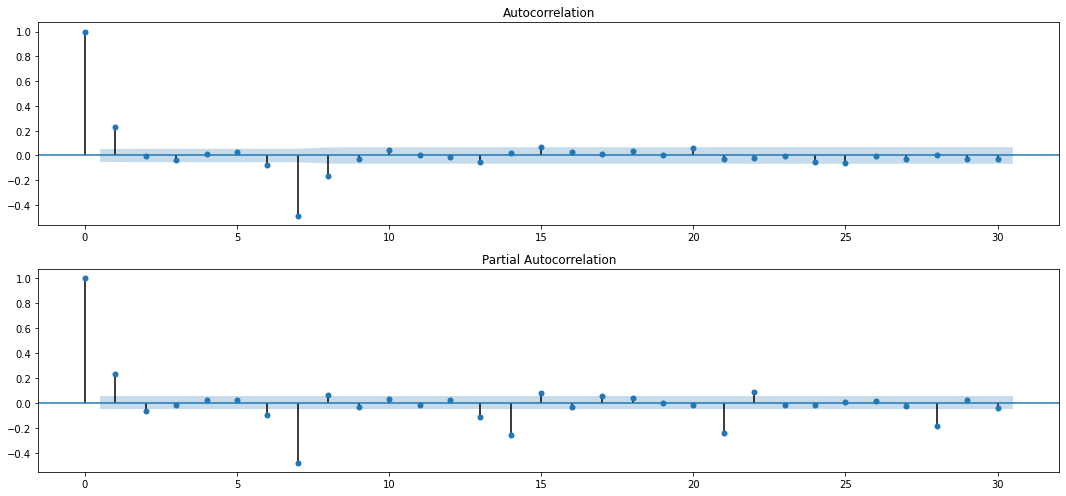

In [ ]:

plt.figure(figsize=(15,7))
ax = plt.subplot(211)

sm.graphics.tsaplots.plot_acf(df_day.prices_box_diff2[13:].values.squeeze(), lags=30, ax=ax)
ax = plt.subplot(212)

sm.graphics.tsaplots.plot_pacf(df_day.prices_box_diff2[13:].values.squeeze(), lags=30, ax=ax)
plt.tight_layout()
plt.show()

# Evaluar modelo (diario)


In [ ]:

# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_day.Weighted_Price_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:     Weighted_Price_box   No. Observations:                 1454
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1704.127
Date:                Thu, 05 Aug 2021   AIC                          -3404.254
Time:                        22:45:00   BIC                          -3393.691
Sample:                    03-09-2017   HQIC                         -3400.312
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2473      0.017     14.685      0.000       0.214       0.280
sigma2         0.0056      0.000     44.588      0.000       0.005       0.006
Ljung-Box (Q):                       47.36   Jarque-

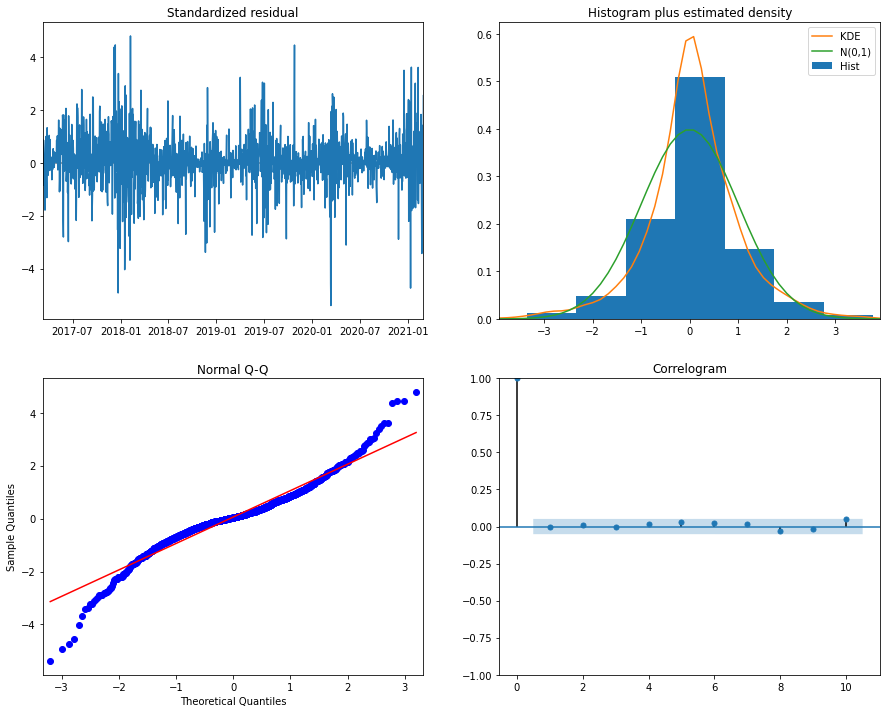

In [ ]:

best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Predicción (diario)

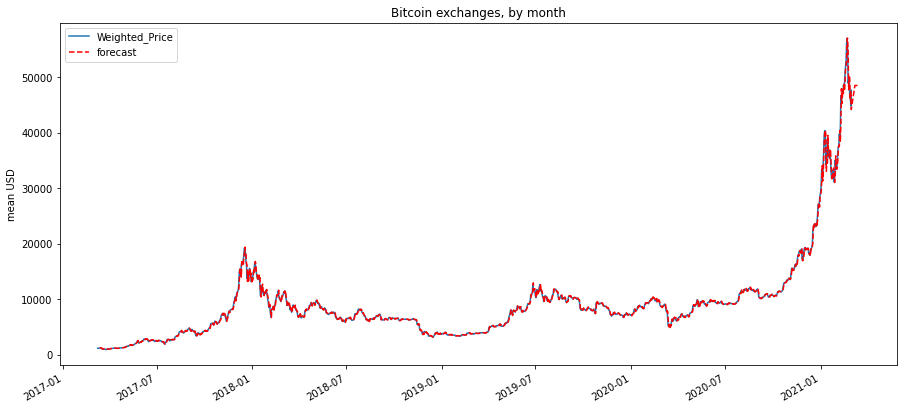

In [ ]:
df_day2 = df_day[['Weighted_Price']]



date_list=[datetime(2021,3,1),datetime(2021,3,8),datetime(2021,3,15)]
future = pd.DataFrame(index=date_list, columns= df_day.columns)
df_day2 = pd.concat([df_day2, future])

df_day2['forecast'] = invboxcox(best_model.predict(start=4, end=1500), lmbda)

plt.figure(figsize=(15,7))
df_day2.Weighted_Price.plot()
df_day2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin exchanges, by month')
plt.ylabel('mean USD')

plt.show()

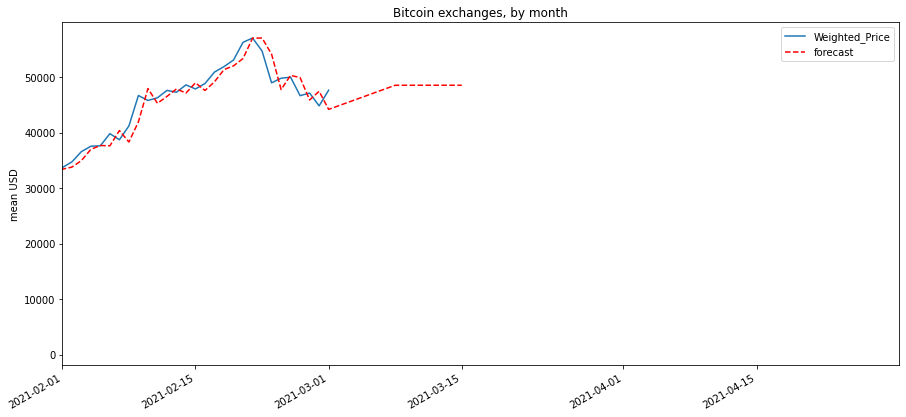

In [ ]:
plt.figure(figsize=(15,7))
df_day2.Weighted_Price.plot()
df_day2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin exchanges, by month')
plt.ylabel('mean USD')
plt.xlim([datetime(2021, 2 , 1), datetime(2021, 4, 30)])
plt.show()

In [ ]:
y_forecasted = df_day2.forecast
y_truth = df_day2['2018-01-01':'2021-03-01'].Weighted_Price

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 549.64


In [ ]:
mae=np.mean(np.abs(y_forecasted-y_truth))
print('Mean Absolute Error: {}'.format(round(mae, 2)))

Mean Absolute Error: 260.64


In [ ]:
mape=np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('Mean Absolute Percentage Error: {}'.format(round(mape, 2)))

Mean Absolute Percentage Error: 2.19


# Estacionaridad para datos (semanal)

In [ ]:
df_week=df.resample('W').mean()

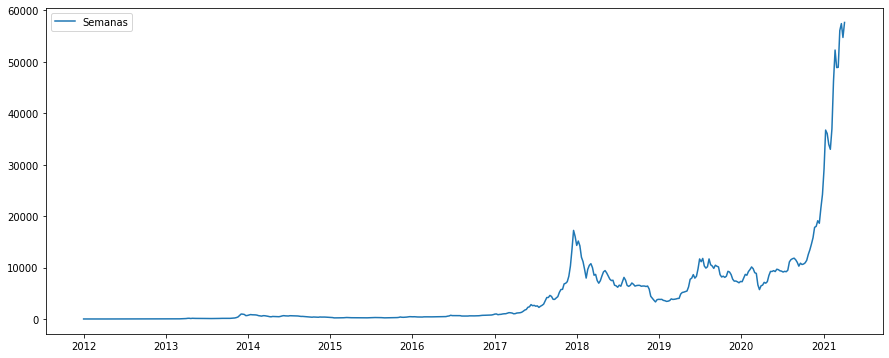

In [ ]:
plt.plot(df_week.Weighted_Price, '-', label='Semanas')
plt.legend()
plt.show()


In [ ]:
test_stationarity(df_week.Weighted_Price)

ADF Stastistic: 2.455084
p-value: 0.999034
No es estacionario


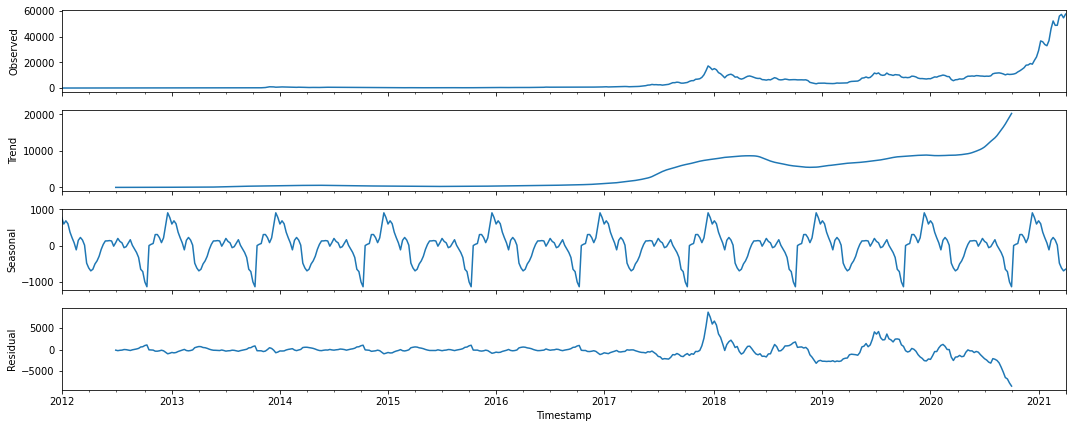

In [ ]:
seasonal_decompose(df_week.Weighted_Price).plot()
plt.show()

In [ ]:
df_week['Weighted_Price_box'], lmbda = stats.boxcox(df_week.Weighted_Price)
test_stationarity(df_week.Weighted_Price_box)

ADF Stastistic: -0.060437
p-value: 0.953239
No es estacionario


In [ ]:
#Diferenciacion seasonal (cada 52 semanas / 1 año)
df_week['prices_box_diff_52'] = df_week.Weighted_Price_box-df_week.Weighted_Price_box.shift(52)
df_week=df_week.dropna()
test_stationarity(df_week.prices_box_diff_52)

ADF Stastistic: -2.354080
p-value: 0.155118
No es estacionario


In [ ]:
#Diferenciacion de primer orden
df_week['prices_box_diff1'] = df_week.Weighted_Price_box-df_week.Weighted_Price_box.shift(1)
df_week=df_week.dropna()
test_stationarity(df_week.prices_box_diff1)

ADF Stastistic: -13.941052
p-value: 0.000000
Se rechaza hipotesis nula, dato es estacionario


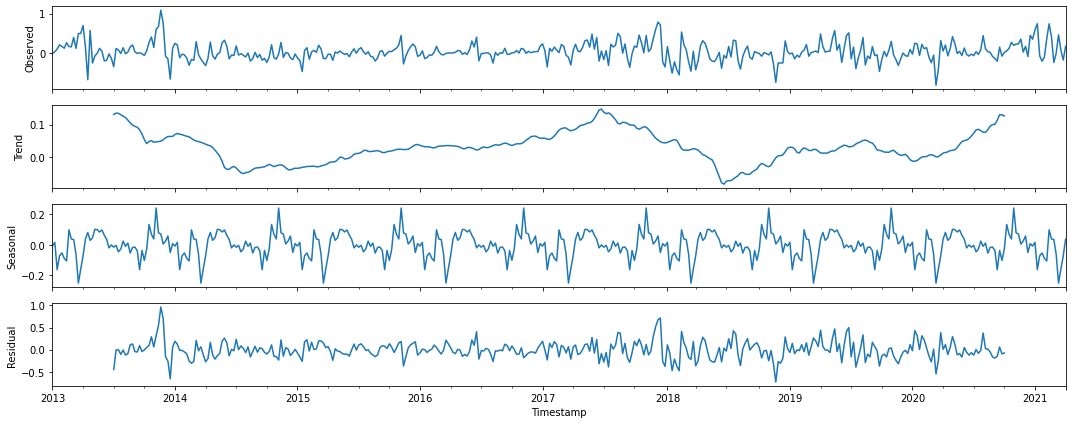

In [ ]:
seasonal_decompose(df_week.prices_box_diff1).plot()
plt.show()

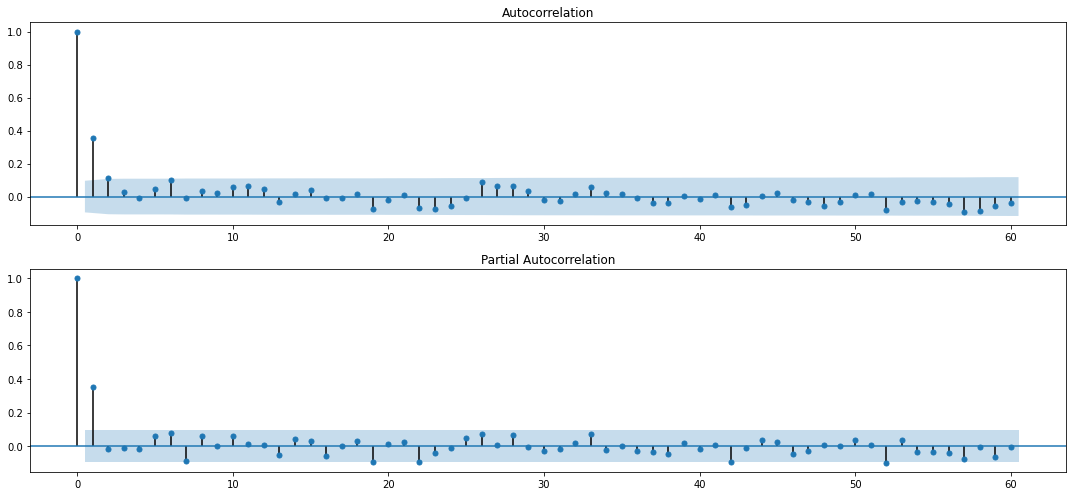

In [ ]:

plt.figure(figsize=(15,7))
ax = plt.subplot(211)

sm.graphics.tsaplots.plot_acf(df_week.prices_box_diff1[13:].values.squeeze(), lags=60, ax=ax)
ax = plt.subplot(212)

sm.graphics.tsaplots.plot_pacf(df_week.prices_box_diff1[13:].values.squeeze(), lags=60, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:

# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(df_week.Weighted_Price_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

   parameters        aic
6      (1, 0) -91.826285
20     (3, 2) -91.499245
23     (3, 5) -90.055444
12     (2, 0) -89.924675
7      (1, 1) -89.922929
                           Statespace Model Results                           
Dep. Variable:     Weighted_Price_box   No. Observations:                  431
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  47.913
Date:                Thu, 05 Aug 2021   AIC                            -91.826
Time:                        22:45:25   BIC                            -83.699
Sample:                    01-06-2013   HQIC                           -88.617
                         - 04-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3954      0.029     13.542      0.000      

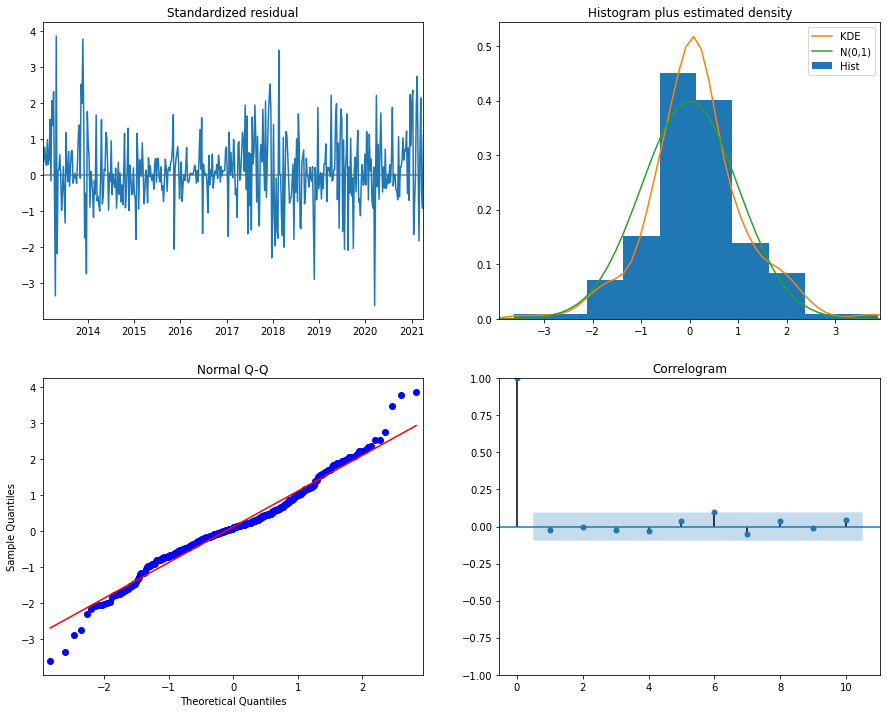

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

# Predicción (semanal)

2017-01-01 00:00:00


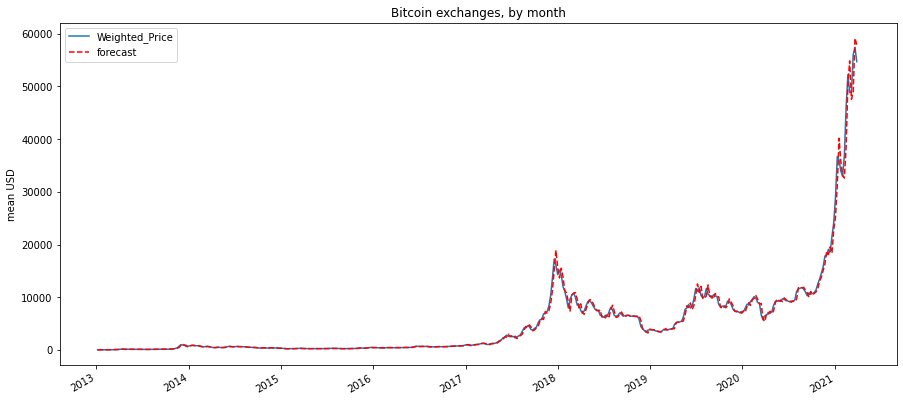

In [ ]:
df_week2 = df_week[['Weighted_Price']]
date_list = [datetime(2021, 3 , 31), datetime(2021, 4, 30), datetime(2021, 5, 31), datetime(2021,6, 30), datetime(2021, 7, 31)]
future = pd.DataFrame(index=date_list, columns= df_week.columns)
df_week2 = pd.concat([df_week2, future])
print(datetime(2017,1,1))
df_week2['forecast'] = invboxcox(best_model.predict(start=0, end=700), lmbda)

plt.figure(figsize=(15,7))
df_week2.Weighted_Price.plot()
df_week2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin exchanges, by month')
plt.ylabel('mean USD')
#plt.xlim([datetime(2012, 8 , 31), datetime(2021, 12, 31)])
plt.show()

In [ ]:
y_forecasted = df_week2.forecast
y_truth = df_week2['2012-01-01':'2017-01-01'].Weighted_Price

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 40.9


In [ ]:
y_forecasted = df_week2.forecast
y_truth = df_week2['2017-01-01':'2021-01-01'].Weighted_Price

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 737.32


In [ ]:
mae=np.mean(np.abs(y_forecasted-y_truth))
print('Mean Absolute Error: {}'.format(round(mae, 2)))

Mean Absolute Error: 495.14


In [ ]:
mape=np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('Mean Absolute Percentage Error: {}'.format(round(mape, 2)))

Mean Absolute Percentage Error: 6.56
